In [1]:
from tensorflow.keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import os
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

### Reading the dataset

In [2]:
Xtr=np.loadtxt("TrainData/TrainData.csv")
Ytr=np.loadtxt("TrainLabels.csv")

#### Visualization of a few images of the items

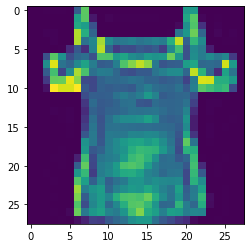

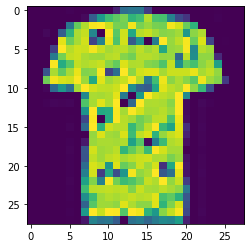

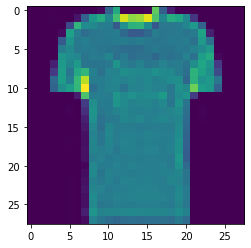

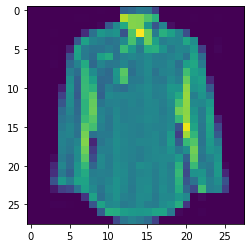

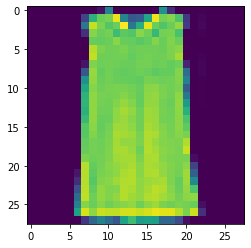

In [19]:
for i in range(-1,-6,-1):
    plt.imshow(Xtr[i].reshape(28,28))
    plt.show()

###  Feature extraction using CNN

In [3]:
X_train = Xtr[:11000]
y_train = Ytr[:11000]
X_test = Xtr[11000:]
y_test = Ytr[11000:]

In [4]:
train_X=np.dstack([X_train] * 3)
test_X=np.dstack([X_test]*3)
train_X.shape

(11000, 784, 3)

In [5]:
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((11000, 28, 28, 3), (1000, 28, 28, 3))

In [6]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

Using TensorFlow backend.


((11000, 48, 48, 3), (1000, 48, 48, 3))

In [7]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [8]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X,y_train,test_size=0.1,random_state=13)

In [10]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((9900, 48, 48, 3), (1100, 48, 48, 3), (9900,), (1100,))

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,Dense,Activation
from tensorflow.keras.layers import  Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras.models import Model

### Feature extraction using VGG16

In [12]:
def extractfeature(X_train):
    X_train = preprocess_input(X_train)
    model = VGG16(weights="imagenet", include_top=False,input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
    features = model.predict(np.array(X_train), batch_size=BATCH_SIZE, verbose=1)
    return features

In [13]:
#model = VGG16(weights='imagenet', include_top=False)
model = VGG16(weights="imagenet", include_top=False,input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [14]:
X_cv = extractfeature(valid_X)
X_train = extractfeature(train_X)
X_test = extractfeature(test_X)

1000/1000 [==============================] - 7s 7ms/sample


In [18]:
X_train.shape

(9900, 1, 1, 512)

### using Simple Logistic Regression to classify the imeags

In [16]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score 

In [19]:
X_train = np.reshape(X_train, (9900, 1*1*512))
X_test = np.reshape(X_test, (1000, 1*1*512))
X_cv = np.reshape(X_cv, (1100, 1*1*512))

## Model using the extracted features

In [21]:
vacc = []
tacc = []
for c in [.01,.1,1,10,100]:   
    model = LR(C = c)
    model.fit(X_train,train_label)
    y_pre = model.predict(X_cv)
    y_pre1 = model.predict(X_train)
    x1 = accuracy_score(valid_label,y_pre)
    x2 = accuracy_score(train_label,y_pre1)
    vacc.append(x1)
    tacc.append(x2) 
    print(c,"Validation ACCURACY---------------->",x1)

C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.01 Validation ACCURACY----------------> 0.7427272727272727
0.1 Validation ACCURACY----------------> 0.7490909090909091


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1 Validation ACCURACY----------------> 0.7527272727272727
10 Validation ACCURACY----------------> 0.7536363636363637


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


100 Validation ACCURACY----------------> 0.7490909090909091


In [22]:
train = X_train
val = X_cv

### finding the optimal value of C using hyperparameter tunning

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xtr,Ytr,test_size=0.1,random_state=13 )
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.1,random_state=13 )

### Hyperparameter tunning of the model using the given features only

In [24]:
vacc = []
tacc = []
for c in [.01,.1,1,10,100]:   
    model = LR(C = c)
    model.fit(X_train,y_train)
    y_pre = model.predict(X_cv)
    y_pre1 = model.predict(X_train)
    x1 = accuracy_score(y_cv,y_pre)
    x2 = accuracy_score(y_train,y_pre1)
    vacc.append(x1)
    tacc.append(x2) 
    print(c,"Validation ACCURACY---------------->",x1)
    print(c,"Training ACCURACY---------------->",x1)

C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.01 Validation ACCURACY----------------> 0.7648148148148148
0.01 Training ACCURACY----------------> 0.7648148148148148


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.1 Validation ACCURACY----------------> 0.7638888888888888
0.1 Training ACCURACY----------------> 0.7638888888888888


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1 Validation ACCURACY----------------> 0.7620370370370371
1 Training ACCURACY----------------> 0.7620370370370371


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10 Validation ACCURACY----------------> 0.7638888888888888
10 Training ACCURACY----------------> 0.7638888888888888


C:\Users\karan\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


100 Validation ACCURACY----------------> 0.7648148148148148
100 Training ACCURACY----------------> 0.7648148148148148


### Applying XGboost

In [174]:
import xgboost as xgb
import scikitplot.metrics as skplt

In [176]:
## hyperparameter tunning
depth=[1, 30, 100,200]
est=[1, 50, 150,300]
roc_auc_cv = []              # to store the cross validation accuracy on the cv dataset (final_cv)
roc_auc_train= []            # to store the training accuracy on the training dataset (final_train)
cv_acc=0
max_auc = 0
opt_sample_est = 0
opt_depth = 0
for d in depth:
    for s in est:
        clf = xgb.XGBClassifier(n_estimators = s,max_depth = d,n_jobs = -1)
        clf.fit(X_train,y_train)
        cv_prediction = clf.predict(X_cv)
        train_prediction = clf.predict(X_train)
        cv_auc = accuracy_score(y_cv, cv_prediction)
        train_acc = accuracy_score(y_train,train_prediction)
        if(max_auc < cv_auc):
            opt_depth = d
            opt_sample_est = s
            max_auc = cv_auc
        roc_auc_cv.append(cv_auc)
        roc_auc_train.append(train_acc)   
print("Max Accuracy Score :",max_auc)
print("Optimal_depth :",opt_depth)
print("Optimal No of estimators :",opt_sample_est)

Max Accuracy Score : 0.8111111111111111
Optimal_depth : 100
Optimal No of estimators : 150


### Creating heatmap to find out the optimal set of hyperparameters

In [177]:
import numpy as np
import seaborn as sns
def createHeatMap(alpha,gamma1,roc_auc_cv1):
    l = []
    for i in alpha:
        for g in gamma1:
            l.append([i,g])
    l = np.asarray(l)
    df = pd.DataFrame(l, columns=['depth','estimators'])
    df['cv_score'] = roc_auc_cv1
    df.head()
    sns.set()
    data = df.pivot("depth", "estimators", "cv_score")
    ax = sns.heatmap(data, annot=True, fmt=".3f")

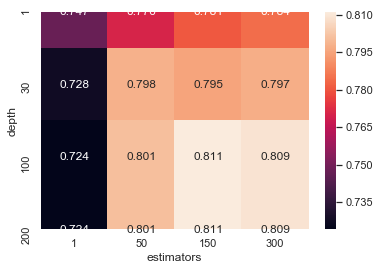

In [178]:
createHeatMap(depth,est,roc_auc_cv)

In [179]:
clf = xgb.XGBClassifier(n_estimators = 150,max_depth = 100,n_jobs = -1)
clf.fit(X_train,y_train)
prediction1 = clf.predict(X_test)

AUC score on test data: 0.8016666666666666
Test confusion matrix


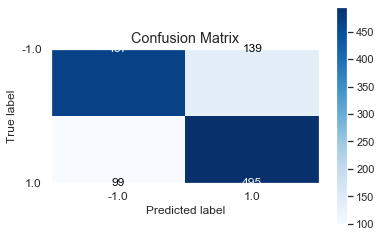

In [181]:
print("AUC score on test data:",accuracy_score(y_test,prediction1))
print("Test confusion matrix")
skplt.plot_confusion_matrix(y_test,clf.predict(X_test))

### Trying Deep Learnning Architecture

In [112]:
from tensorflow.keras.utils import to_categorical
y_train1 = to_categorical(y_train)
y_val1 = to_categorical(y_val)

In [113]:
NB_TRAIN_SAMPLES = train.shape[0]
NB_VALIDATION_SAMPLES = val.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(Dense(512, activation='relu', input_dim=(1*1*512)))
#model.add(relu(train,alpha=0.1))
model.add(Dense(num_classes, activation='softmax'))

In [114]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(),metrics=['acc'])

In [117]:
history = model.fit(train,y_train1,epochs=NB_EPOCHS,validation_data=(val, y_val1),)

Train on 9900 samples, validate on 1100 samples
Epoch 1/100
9900/9900 [==============================] - 4s 373us/sample - loss: 4.6628e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/100
9900/9900 [==============================] - 1s 82us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/100
9900/9900 [==============================] - 1s 82us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/100
9900/9900 [==============================] - 1s 89us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/100
9900/9900 [==============================] - 1s 95us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/100
9900/9900 [==============================] - 1s 91us/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/100
9900/9900 [==============================] - 1s 93us/sample - l

- We can see that deep learning architecture using the feature extraction is performing very bad, one of the reason of it could be the very less train data